In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00

In [2]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00
from jax.config import config
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)


In [3]:
import itertools
import math
from functools import partial

import numpy as onp

import jax
print("jax version: ", jax.__version__)
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import scipy

import jax_cosmo as jc
print("jax-cosmo version:", jc.__version__)

import imnn
print("IMNN version: ", imnn.__version__)

from imnn.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from imnn.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from imnn.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)


jax version:  0.2.10


<ipython-input-3-2c9e9f9c35c9>:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


jax-cosmo version: 0.1rc7
IMNN version:  0.3dev


In [4]:
!XLA_FLAGS=--xla_cpu_enable_fast_math=false

In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Model in STAX

In [6]:
n_summaries = 2
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

In [7]:
# define inception block layer

def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3,3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5,5), strides, padding="SAME")) 
    
    maxpool = stax.serial(stax.MaxPool((3,3), padding="SAME"),
                         stax.Conv(filters4, (1,1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)
    
    
def Reshape(newshape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
    return init_fun, apply_fun    


In [8]:
rng,drop_rng = jax.random.split(rng)
fs = 64 #for 128x128 sims
               

model = stax.serial(
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
)

def get_model(filters=64):
    return stax.serial(
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
        )

In [9]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [10]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [11]:
rng, abc_key = jax.random.split(rng)

# Fields with Jax - Cosmo

In [12]:
cosmo_fid = jc.Planck15(Omega_c=0.85, sigma8=0.75)

In [13]:
# SET 32-BiT floats for model !
θ_fid = np.array([cosmo_fid.Omega_c, cosmo_fid.sigma8], dtype=np.float32)
δθ = np.array([0.1, 0.1], dtype=np.float32)
n_params = 2
N = 128 # 32
dim = 2
L = 250. # 62

field_shape = (N,N)
input_shape = (1,1, N,N)
simulator_args = {"N": N, "L": L, "dim": dim, "shape": field_shape, 'vol_norm': False, "N_scale": True, "squeeze": False}

In [14]:
# define noise
rng,fg_key = jax.random.split(rng)
foregrounds = jax.random.normal(fg_key, (1000, 1,) + simulator_args['shape'])*0


def simulator(rng, θ, simulator_args=simulator_args):
    def P(k, A=1, B=1):
        # define cosmology with parameters
        cosmo = jc.Planck15(Omega_c=A, sigma8=B)
        return jc.power.linear_matter_power(cosmo, k)

    
    def fn(key, A, B):
        
        shape = simulator_args["shape"]
        
        k = np.sqrt(np.sum(np.array(np.meshgrid(*(
            (np.hstack((np.arange(0, _shape//2 + 1), 
                np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
                for _shape in shape))), axis=0))
        
        new_shape = ()
        for _shape in shape:
            if _shape % 2 == 0:
                new_shape += (_shape+1,)
            else:
                new_shape += (_shape,)
        
        
        key1,key2 = jax.random.split(key)
        
        foreground = foregrounds[jax.random.randint(key2, 
                                        minval=0, maxval=1000, shape=())]
        
        # L is in length units, like Gpc
        L = simulator_args['L']
        dim = simulator_args['dim']
        
        if np.isscalar(L):
            L = [L]*int(dim)
        
        else:
            L = np.array(L)
            
        
        V = np.prod(np.array(L))
        
        scale = V**(1./dim)
        
        Lk = ()
        
        _N = 1
        for i,_shape in enumerate(shape):
            _N *= _shape
            Lk += (_shape / L[i],) # 1 / dx
            
    
        # ifft is N/L
        # fft is L/N
        
        fft_norm = np.prod(np.array(Lk))
        #fft_norm = 1 / ifft_norm
        
        _dims = len(shape)
        tpl = ()
        for _d in range(_dims):
            tpl += (_d,)


        # POWERBOX IMPLEMENTATION

        mag = jax.random.normal(key1, shape=tuple(N for N in new_shape))
        # random phases
        pha = 2 * np.pi * jax.random.uniform(key1, shape=tuple(N for N in new_shape))
        # now make hermitian field (reality condition)
        revidx = (slice(None, None, -1),) * len(mag.shape)      
        mag = (mag + mag[revidx]) / np.sqrt(2) 
        pha = (pha - pha[revidx]) / 2 + np.pi
        dk = mag * (np.cos(pha) + 1j * np.sin(pha)) # output is complex
        
        cutidx = (slice(None, -1),) * len(new_shape)
        dk = dk[cutidx]
        
        # power spectrum
        powers = np.concatenate((np.zeros(1), 
                    np.sqrt(P(k.flatten()[1:], A=A, B=B)))).reshape(k.shape)

        
        # normalize power by volume
        if simulator_args['vol_norm']:
            powers /= V
             
        
        # do lognormal transformation
        powers = np.real(np.fft.ifftshift(np.fft.ifftn(powers)*fft_norm)*V)

    
        powers = np.log(1. + powers)
        powers = np.abs(np.fft.fftn(powers))  
        
        # now multiply by random field
        fourier_field = powers * dk
        
        fourier_field = jax.ops.index_update(
            fourier_field,
            np.zeros(len(shape), dtype=int),
            np.zeros((1,)))
        
        
        field = np.sqrt(V) * np.real(np.fft.ifftn(fourier_field))*fft_norm 
        
        
        sg = np.var(field)
        field = np.exp(field - sg / 2.) - 1.
        
                
        field = np.expand_dims(field, (0,))
        
        
        if simulator_args["N_scale"]:
            field *= scale
        
        if not simulator_args["squeeze"]:
            field = np.expand_dims(field, (0,))

        return np.array(np.real((field)), dtype='float32')
        
    shape = simulator_args["shape"]
    # unpack parameters Omega_c, sigma8
    A,B = θ
    cosmo = jc.Planck15(Omega_c=A, sigma8=B)
    
    # TODO: should we define k here ?
    #k = np.sqrt(np.sum(np.array(np.meshgrid(*(((2. * np.pi) / N) * np.arange(N // 2) for N in shape)))**2., 0))
    
    
    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
            )(keys, B)

## sim and gradient

In [15]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [16]:
rng, key = jax.random.split(rng)

In [17]:
# plot example simulation and derivative # L = 250
deriv_args = {"N": 128, "L": 250., "dim": 2, "shape": (128,128), "vol_norm": True, "N_scale": False, "squeeze": False}
simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, simulator_args=deriv_args)

/mnt/home/tmakinen/anaconda3/envs/pyjax9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


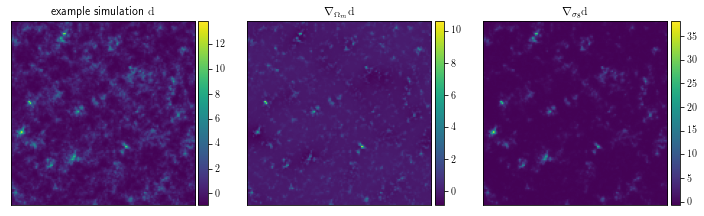

In [18]:
# make a nice plot of our simulations
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(12,15))
#plt.style.use('default')
im1 = ax[0].imshow(np.squeeze(simulation[0]), extent=(0,1,0,1))
ax[0].title.set_text(r'example simulation $\rm d$')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[1].imshow(np.squeeze(simulation_gradient).T[0].T, extent=(0,1,0,1))
ax[1].title.set_text(r'$\nabla_{\Omega_m} \rm d$')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im1 = ax[2].imshow(np.squeeze(simulation_gradient).T[1].T, extent=(0,1,0,1))
ax[2].title.set_text(r'$\nabla_{\sigma_8} \rm d$')
#fig.colorbar(mappable = l, ax=ax[2])

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    
plt.show()

# numerical Fisher information

# numerical Fisher

In [24]:
# compute numerical fisher information
shape = (N,N)
kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    (np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
        for _shape in shape))), axis=0))

def cosmo_pk(k, A=1, B=1):
    # define cosmology with parameters
    cosmo = jc.Planck15(Omega_c=A, sigma8=B)
    return jc.power.linear_matter_power(cosmo, k)

def log_likelihood(k, A, B, Δ, pk, L):
    Δ = Δ.flatten()[:]
    k = k
    _A = A
    _B = B
    
    dlength = len(k.flatten())

    nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
    nrm = jax.ops.index_update(
      nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
    nrm = 1

    powers = pk(k.flatten()[:], A=_A, B=_B) #* L**2

    # covariance is P(k)
    C = powers * nrm
    invC = 1./ powers

    logdetC = np.sum(np.log(C))
    pi2 = np.pi * 2.
    m_half_size = -0.5 * len(Δ)
    exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
    norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
    return np.real(exponent + norm)

sim_args = {"N": N, "L": L, "dim": 2, "shape": field_shape, "vol_norm": True, "N_scale": False, "squeeze": False}


def score(A, B, key):
    θ = np.array([A,B])
    L = 62.
    sim = simulator(key, θ, simulator_args=sim_args)
    Δ = np.fft.fftn(np.squeeze(sim))[1:N//2, 1:N//2]
    k = kbin[1:N//2, 1:N//2]
    pk = cosmo_pk
    
    return log_likelihood(k, A, B, Δ, pk, L)

@jax.jit
def dlnLdθ(A, B, key):
    return jax.grad(score, argnums=(0, 1))(A, B, key)

def numeric_F(A, B, key, n_samples):
    keys = np.array(jax.random.split(key, num=n_samples))
    return np.cov(np.array(jax.vmap(dlnLdθ)(np.repeat(A, n_samples), np.repeat(B, n_samples), keys)))

In [72]:
rng, key = jax.random.split(rng)
_a,_b = θ_fid
F_expected = numeric_F(np.array(_a), np.array(_b), key, 20)
detF_expected = np.linalg.det(F_expected)

print('expected F: ', F_expected)
print('expected det F: ', detF_expected)


expected F:  [[0.02416238 0.07165013]
 [0.07165013 0.23474698]]
expected det F:  0.0005383034


In [51]:
rng, key = jax.random.split(rng)
_a,_b = θ_fid

_detFs = []
_Fs = [] 
for i in range(40):
    rng, key = jax.random.split(rng)
    F_expected = numeric_F(np.array(_a), np.array(_b), key, 30)
    _detFs.append(np.linalg.det(F_expected))
    _Fs.append(F_expected)
    
detF_expected = np.mean(np.array(_detFs))
F_expected = np.mean(np.array(_Fs), axis=0)
print('expected F: ', F_expected)
print('expected det F: ', detF_expected)

expected F:  [[ 45.74586 119.40853]
 [119.40853 312.98715]]
expected det F:  57.02253


# Make Target Data before IMNN training
We're going to create target data with Planck cosmological paramters beforehand in case we need to iterate our poorly-trained fiducial IMNN towards the correct compression.

In [118]:
#simulator_args = {"N": N, "L": 250, "dim": dim, "shape": (128,128), "N_scale": False, "vol_norm": True, "squeeze": True}
simulator_args = {"N": N, "L": L, "dim": dim, "shape": (N,N), "N_scale": False, "vol_norm": True, "squeeze": True}
cosmo_target = jc.Planck15()
θ_target = np.array([cosmo_target.Omega_c, cosmo_target.sigma8])

rng, key = jax.random.split(rng)
#θ_target = np.array([0.4, 0.85])
target_data = simulator(
    key,
    θ_target,
    simulator_args={**simulator_args, **{'squeeze':False}})

/mnt/home/tmakinen/anaconda3/envs/pyjax9/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5179: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [119]:
target_data = np.expand_dims(target_data, 0)
target_data.shape

(1, 1, 1, 128, 128)

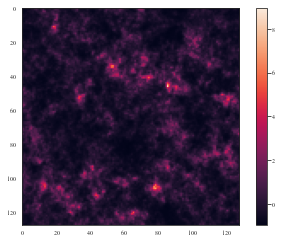

In [120]:
plt.imshow(np.squeeze(target_data))
plt.colorbar()

# Initialise IMNN

In [22]:
simulator_args["squeeze"] = False

In [23]:
simulator_args['vol_norm'] = True
simulator_args['N_scale'] = False # false 
simulator_args['L'] = L

In [24]:
simulator_args

{'N': 128,
 'L': 250.0,
 'dim': 2,
 'shape': (128, 128),
 'N_scale': False,
 'vol_norm': True,
 'squeeze': False}

In [42]:
# SAVING IMNN ATTRIBUTES
import cloudpickle as pickle
import os

def save_weights(IMNN, folder_name='./model', weights='final'):
    
    # create output directory
    if not os.path.exists(folder_name): 
        os.mkdir(folder_name)
    
    def pckl_me(obj, path):
        with open(path, 'wb') as file_pi:
            pickle.dump(obj, file_pi)
        file_pi.close()
        
    # save IMNN (optimiser) state:
    savestate = jax.experimental.optimizers.unpack_optimizer_state(IMNN.state)
    pckl_me(savestate, os.path.join(folder_name, 'IMNN_state'))
    
    # save weights
    if weights == 'final':
        np.save(os.path.join(folder_name, 'final_w'), IMNN.final_w)
    
    else:
        np.save(os.path.join(folder_name, 'best_w'), IMNN.best_w)
        
    # save initial weights
    np.save(os.path.join(folder_name, 'initial_w'), IMNN.initial_w)
        
    # save training history
    pckl_me(IMNN.history, os.path.join(folder_name, 'history'))
    
    # save important attributes as a dict
    imnn_attributes = {
        'n_s': IMNN.n_s,
        'n_d': IMNN.n_d,
        'input_shape': IMNN.input_shape,
        'n_params' : IMNN.n_params,            
        'n_summaries': IMNN.n_summaries,
        'θ_fid': IMNN.θ_fid,
        'F': IMNN.F,   
        'validate': IMNN.validate,
        'simulate': IMNN.simulate,
        
    }
    
    pckl_me(imnn_attributes, os.path.join(folder_name, 'IMNN_attributes'))
    
    print('saved weights and attributes to the file ', folder_name)
    
    
def load_weights(IMNN, folder_name='./model', weights=None, load_attributes=True):
    
    
    def unpckl_me(path):
        file = open(path, 'rb')
        return pickle.load(file)
    
    # load and assign weights
    if weights is not None:
        weights = np.load(os.path.join(folder_name, 'final_w.npy'),  allow_pickle=True)
        IMNN.final_w = weights
    else:
        weights = np.load(os.path.join(folder_name, 'best_w.npy'),  allow_pickle=True)
        IMNN.best_w = weights
        
    # re-pack and load the optimiser state
    loadstate = unpckl_me(os.path.join(folder_name, 'IMNN_state'))
    IMNN.state = jax.experimental.optimizers.pack_optimizer_state(loadstate)
    
    
    # load history
    IMNN.history = unpckl_me(os.path.join(folder_name, 'history'))
    
    # load important attributes
    if load_attributes:
        IMNN.intial_w =  np.load(os.path.join(folder_name, 'initial_w.npy'), allow_pickle=True)
        attributes = unpckl_me(os.path.join(folder_name, 'IMNN_attributes'))
        IMNN.θ_fid = attributes['θ_fid']
        IMNN.n_s = attributes['n_s']
        IMNN.n_d = attributes['n_d']
        IMNN.input_shape = attributes['input_shape']
        
    print('loaded IMNN with these attributes: ', attributes)
    

In [72]:
# load model state
def unpckl_me(path):
    file = open(path, 'rb')
    return pickle.load(file)

loadstate = unpckl_me(os.path.join('./cosmo-test', 'IMNN_state'))
loadstate = jax.experimental.optimizers.pack_optimizer_state(loadstate)

In [73]:
IMNN = AggregatedSimulatorIMNN(
        n_s=5000,
        n_d=5000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=loadstate,#initial_model_key,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        host=jax.devices()[0],
        devices=[jax.devices()[0]],
        n_per_device=1000
        )

# Iterative Fitting

In [74]:
θ_fid

DeviceArray([0.85, 0.75], dtype=float32)

In [75]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);
    
#save_weights(IMNN, folder_name='./big_incept128')

CPU times: user 26min 33s, sys: 6min 11s, total: 32min 44s
Wall time: 32min 30s


In [76]:
np.linalg.det(IMNN.F)

DeviceArray(179429.56, dtype=float32)

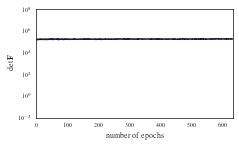

In [79]:
latexify(fig_width=3.37)
plt.plot(IMNN.history['detF'][:])
#plt.plot(np.ones(len(IMNN.history['detF'][:]))*detF_expected, c='k', linestyle='--')
plt.ylim(1e-2, 1e8)
plt.ylabel(r'$\det \textbf{F}$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-training.png', dpi=400)

# Do inference

In [80]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)


In [127]:
prior = uniform([-0.1, -0.1], [1.5, 1.5])

In [128]:
IMNN.F

DeviceArray([[ 573.38873, 1061.0817 ],
             [1061.0817 , 2276.5078 ]], dtype=float32)

# Gaussian approximation

In [129]:
estimates = IMNN.get_estimate(target_data) #[i.get_estimate(target_data) for i in IMNNs];

In [130]:
estimates

DeviceArray([[0.08492696, 0.8220178 ]], dtype=float32)

In [131]:
GAs = [GaussianApproximation(IMNN.get_estimate(target_data), IMNN.invF, prior)]
       #GaussianApproximation(get_estimate(target_data), np.linalg.inv(f_expected), prior)]

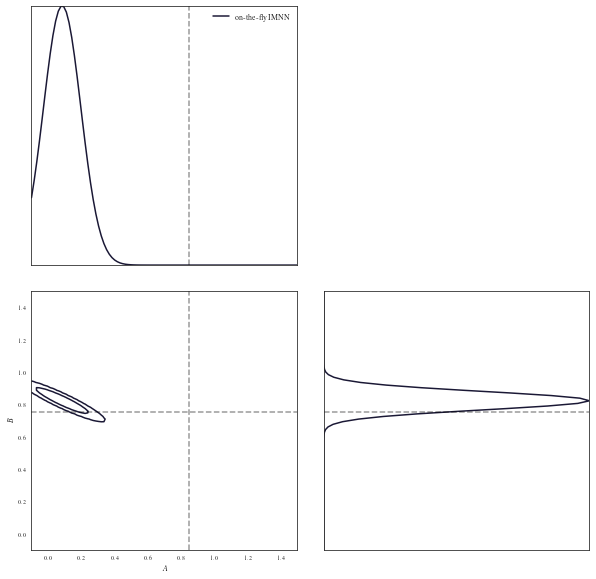

In [132]:
%matplotlib inline
for i, (GA, label) in enumerate(zip(GAs, ['sim IMNN'])):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$A$", r"$B$"], label='on-the-fly IMNN', colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label='sim IMNN', colours="C{}".format(i), ncol=8)
        
        
ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')


# re-train IMNN
We see that the estimate has moved far from the fiducial, so we re-train on the current IMNN's target data estimates.

In [140]:
simulator_args['squeeze'] = False

In [141]:
np.squeeze(estimates)

DeviceArray([0.08492696, 0.8220178 ], dtype=float32)

In [142]:
IMNN = AggregatedSimulatorIMNN(
        n_s=5000,
        n_d=5000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=np.squeeze(estimates),
        model=model,
        optimiser=optimiser,
        key_or_state=initial_model_key,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        host=jax.devices()[0],
        devices=[jax.devices()[0]],
        n_per_device=1000
        )

In [ ]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);

# ABC

In [116]:
{**simulator_args, **{'squeeze':False}}

{'N': 128,
 'L': 250.0,
 'dim': 2,
 'shape': (128, 128),
 'N_scale': False,
 'vol_norm': True,
 'squeeze': False}

In [117]:
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : simulator(A,B, simulator_args={**simulator_args, **{'squeeze':False}}), 
                                       IMNN.get_estimate, F=IMNN.F, gridsize=50
    )

In [ ]:
%%time
rng,abc_key = jax.random.split(rng)
ABC(rng=abc_key,
        n_samples=int(1e3),
        min_accepted=15000,
        max_iterations=50000,
        ϵ=0.01,
        smoothing=0.);

In [123]:
ABC.parameters.accepted[0].shape

(6, 2)

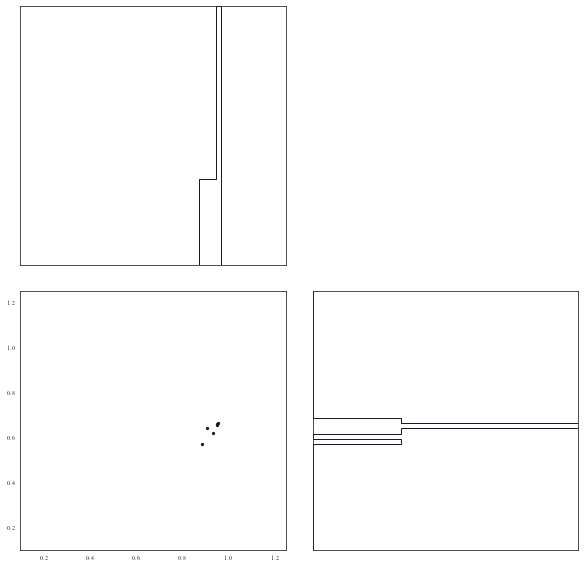

In [124]:
#ax = ABC.scatter_plot(points=ABC.parameters.rejected, colours='red')
ax = ABC.scatter_plot()

In [110]:
#np.save("accepted.npy", ABC.parameters.accepted)

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

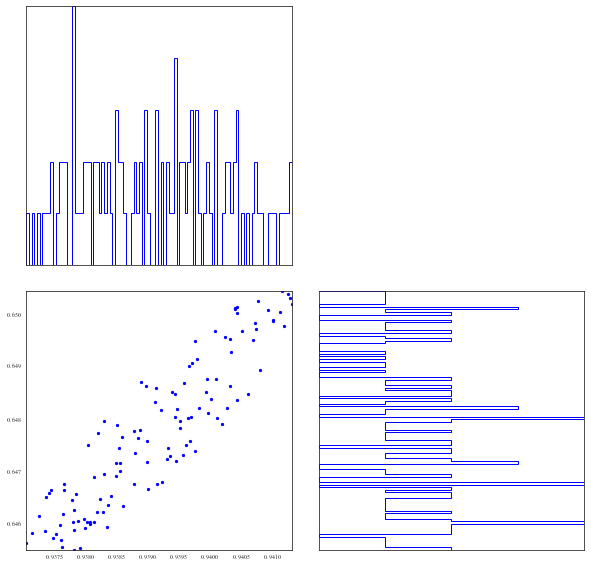

In [68]:
#ax = ABC.scatter_summaries(points=ABC.summaries.rejected, colours='red')
ABC.scatter_summaries( colours='blue')

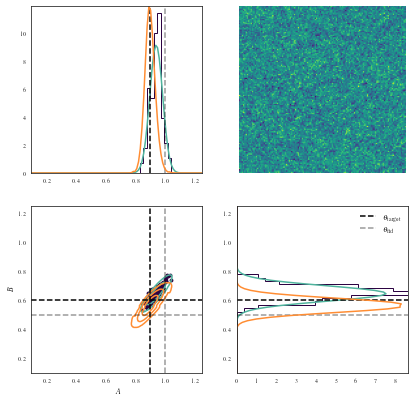

In [94]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
#fig = plt.figure(constrained_layout=True, figsize=(3.41*1., 3.41*1.))
#fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
#ax = fig.subplots(nrows=2, ncols=2)
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.41*1., 3.41*1.), 
                      gridspec_kw={'height_ratios': [1, 1], 'width_ratios':[1,1]})
latexify(fig_width=3.41, fig_height=3.41)

# just to fiddle with the label
ax[0,0].plot(0.3, 0., color=new_colors[0],
           marker='o', label='ABC')

cmap_reversed = matplotlib.cm.get_cmap('viridis_r')



ax = GAs[0].marginal_plot(ax=ax, colours='#00c133', #new_colors[1], 
                          axis_labels=[r"$A$", r"$B$"], label="Gaussian Approximation", ncol=1,
                            linestyle='dotted')
ax[0,0].legend(framealpha=0.)
ax[0,1].imshow(np.squeeze(target_data), cmap='viridis')


ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$\Omega_m$')
ax[1,0].set_ylabel(r'$\sigma_8$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

ax[1,1].legend(framealpha=0.)



# ABC scatter plots
ax[0,0].hist(ABC.parameters.accepted[0][:, 0], color=new_colors[0], histtype='step', density=True)
ax[1,0].scatter(ABC.parameters.accepted[0][:, 0], ABC.parameters.accepted[0][:, 1], s=8, alpha=0.6,
                c=np.log(ABC.distances.accepted[0]), cmap='Purples', edgecolors=None, linewidths=0, marker='.')

ax[1,1].hist(ABC.parameters.accepted[0][:, 1], color=new_colors[0], 
             histtype='step', density=True, orientation='horizontal')


#ax[1,0].legend(framealpha=0.)



# ax[0,0].set_xlim(0.55, 1.1)
# #ax[0,0].set_ylim(0., 10.1)
# ax[1,0].set_xlim(0.55, 1.1)
# ax[1,0].set_ylim(0.3, 0.9)
# ax[1,1].set_ylim(0.3, 0.9)

ax[0,0].legend(framealpha=0., bbox_to_anchor=(1.08, 1.5), frameon=False)


ax[1,1].set_yticks([])
ax[1,1].set_xticks([])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

#ax[0,0].set_ylabel(r'$\mathit{P}(A|\textbf{x})$')
#ax[1,1].set_xlabel(r'$\mathit{P}(B|\textbf{x})$')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.tight_layout()

#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-cosmo-inference-.png', dpi=400, bbox_inches='tight')
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [78]:
# Create figures in Python that handle LaTeX, and save images to files in my
# preferred formatting. I typically place this code in the root of each of my
# projects, and import using:
# from latexify import *
# which will also run the latexify() function on the import.

# Based on code from https://nipunbatra.github.io/blog/2014/latexify.html

import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

#Back-end to use depends on the system
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
# matplotlib.use('pgf')
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# matplotlib.backend_bases.register_backend('ps', FigureCanvasPgf)

import seaborn as sns
sns.set_style("white")

#my preferred palette. From
#https://seaborn.pydata.org/tutorial/color_palettes.html: "The cubehelix color
#palette system makes sequential palettes with a linear increase or decrease in
#brightness and some variation in hue. This means that the information in your
#colormap will be preserved when converted to black and white (for printing) or
#when viewed by a colorblind individual."

# I typically set the number of colors (below, 8) to the distinct colors I need
# in a given plot, so as to use the full range.
sns.set_palette(sns.color_palette("cubehelix", 8))


# The following is the latexify function. It allows you to create 2 column or 1
# column figures. You may also wish to alter the height or width of the figure.
# The default settings are good for most cases. You may also change the
# parameters such as labelsize and fontsize based on your classfile.
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1, 2])

    if fig_width is None:
        fig_width = 6.9 if columns == 1 else 13.8  # width in inches #3.39

    if fig_height is None:
        golden_mean = (sqrt(5) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean  # height in inches

    MAX_HEIGHT_INCHES = 16.0
    if fig_height > MAX_HEIGHT_INCHES:
        print(("WARNING: fig_height too large:" + fig_height +
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches."))
        fig_height = MAX_HEIGHT_INCHES

    params = {
            # 'backend': 'ps',
           #   'pgf.rcfonts': False,
           #   'pgf.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
           #   "pgf.texsystem": "pdflatex",
             # 'text.latex.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
              'text.latex.preamble': '\\usepackage{mathptmx}',
              #values below are useful defaults. individual plot fontsizes are
              #modified as necessary.
              'axes.labelsize': 8,  # fontsize for x and y labels
              'axes.titlesize': 8,
              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 6,
              'ytick.labelsize': 6,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'font.serif': 'Times',
               'lines.linewidth': 1.5,
               'lines.markersize':1,
               'xtick.major.pad' : 2,
               'ytick.major.pad' : 2,
                'axes.xmargin' :  .0,  # x margin.  See `axes.Axes.margins`
                'axes.ymargin' : .0,  # y margin See `axes.Axes.margins`
              }

    matplotlib.rcParams.update(params)

def saveimage(name, fig = plt, extension = 'pdf', folder = 'plots/'):
    sns.despine()

    #Minor ticks off by default in matplotlib
    # plt.minorticks_off()

    #grid being off is the default for seaborn white style, so not needed.
    # plt.grid(False, axis = "x")
    # plt.grid(False, axis = "y")
    
    fig.savefig('{}{}.{}'.format(folder,name, extension), bbox_inches = 'tight')

latexify()